In [1]:
import os
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm
sns.set(style="darkgrid")

In [2]:
minute_interval = 5
non_reoccuing_number = 100

# (hours / minute_interval) +1 0,2,4,8,12,24,47+3/4 or 47+11/12
#15 min 
coeff_indexes_15 = [1, 9, 17, 33, 49, 97, 191] 
#5 min
coeff_indexes_5 = [1, 25, 49, 97, 145, 289, 575]

if (minute_interval == 15):
    ar_coeff_indexes = coeff_indexes_15
else:
    ar_coeff_indexes = coeff_indexes_5

In [3]:
data = pd.read_csv(f"../../data/corrected_data_{minute_interval}_{non_reoccuing_number}.csv")

In [6]:
hash_group = data.groupby(['hash'])
data['ndt'] = pd.to_datetime(data.date) + data.hours.astype('timedelta64[h]') + data.minutes.astype('timedelta64[m]')
hash_dt = data.drop(columns=['hours','minutes']).groupby(['hash','ndt']).sum()

In [6]:
def get_maxlag(data_length):
    minute_length = data_length*minute_interval
    # hold_back needs to be taken into account, will be equal to # of lags 
    max_lag = data_length/2 # Split into hold_back and lags
    
    if (minute_length > 2880): #48 hours
        lag = int(2880/minute_interval)
        if (lag < max_lag):
            return lag-1
    if (minute_length > 1440): #24
        lag = int(1440/minute_interval)
        if (lag < max_lag):
            return lag-1
    if (minute_length > 720): #12
        lag = int(720/minute_interval)
        if (lag < max_lag):
            return lag-1
    if (minute_length > 480): #8
        lag = int(480/minute_interval)
        if (lag < max_lag):
            return lag-1
    if (minute_length > 240): #4
        lag = int(240/minute_interval)
        if (lag < max_lag):
            return lag-1
    if (minute_length > 120): #2
        lag = int(120/minute_interval)
        if (lag < max_lag):
            return lag-1
    return int(max_lag-1)

In [7]:
def get_ar_params(params, coeff_indexes):
    param_len = len(params)
    coeff_index = 0
    return_params = []
    return_params.append(params[0])
    for i in range(0, param_len):
        if i == coeff_indexes[coeff_index]:
            return_params.append(params[i])
            coeff_index+=1
    while (len(return_params) != len(coeff_indexes)+1):
        return_params.append(0)
    return return_params

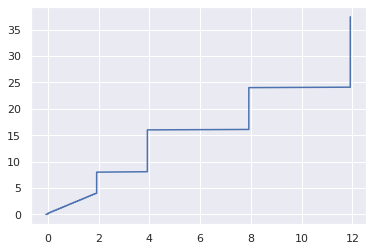

In [8]:
values = [(get_maxlag(x)*minute_interval/60) for x in range(0, 450)]
plt.plot(values, [x*minute_interval/60 for x in range(0, 450)])

# Features

In [9]:
data_features = pd.DataFrame()

## About
This notebook calculates the features to be used for clustering.


## Calculated features

* Mean
* Original occurances
* Standard deviation
* Skew
* N-highest values
* Number of local extrems above the interval of confidence
* Akaike information criterion (AIC)
* Bayesian information criterion (BIC)
* Parameters of the fitted function
* Statistical parameters from differentiated series
* Lifespan
* Sum

## TS - Example and explanation

In [7]:
hash_id = "60a8863c06fb37039ab542ba5450ebd7"
ex_h_data = hash_dt.xs(hash_id, level='hash').sort_values(['ndt'])
ex_h_non_zero_occurances = len(ex_h_data)
ex_h_date_range = pd.date_range(start=ex_h_data.index[0].date(), end=ex_h_data.index[-1].date())
ex_h_data = ex_h_data.resample(f'{minute_interval}T').sum().fillna(0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


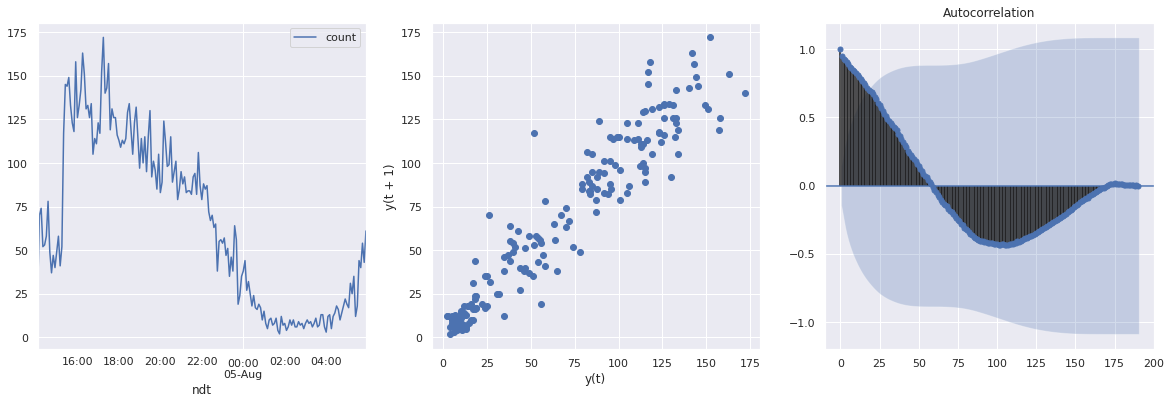

In [11]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20, 6)
ex_h_data.plot(ax=ax[0])
pd.plotting.lag_plot(ex_h_data,ax=ax[1])
sm.graphics.tsa.plot_acf(ex_h_data, ax=ax[2], lags=190)
plt.show()
#pd.plotting.autocorrelation_plot(h_data,ax=ax[2])

In [12]:
ex_h_occurances = len(ex_h_data)
ex_h_mean = ex_h_data.mean()[0]
ex_h_std = ex_h_data.std()[0]
ex_h_skew = ex_h_data.skew()[0]
ex_largest = ex_h_data.nlargest(3,'count').values
ex_h_l1 = ex_largest[0]
ex_h_l2 = ex_largest[1]
ex_h_l3 = ex_largest[2]
ex_h_c95 = ex_h_mean + (1.96 * (ex_h_std/ex_h_occurances))
ex_h_local_maxima = argrelextrema(ex_h_data.values, np.greater)[0]
ex_h_c95_above = len([x for x in ex_h_local_maxima if x > ex_h_c95])
ex_res = AutoReg(ex_h_data.values, lags = get_maxlag(len(ex_h_data))).fit()#[12, 72, 144]).fit()
ex_h_ar_aic = ex_res.aic
ex_h_ar_bic = ex_res.bic
ex_h_ar_params = get_ar_params(ex_res.params, ar_coeff_indexes)
ex_h_diff = ex_h_data.diff()
ex_h_diff_mean = ex_h_diff.mean()[0]
ex_h_diff_std = ex_h_diff.std()[0]
ex_h_diff_skew = ex_h_diff.skew()[0]
ex_h_lf = len(ex_h_date_range) 
ex_h_sum = ex_h_data['count'].sum()

In [13]:
print(f'Mean: {ex_h_mean}')
print(f'Occurances: {ex_h_occurances}')
print(f'std: {ex_h_std}')
print(f'skew: {ex_h_skew}')
print(f'largest 1: {ex_h_l1[0]}')
print(f'largest 2: {ex_h_l2[0]}')
print(f'largest 3: {ex_h_l3[0]}')
print(f'local maxima above 95% confidence: {ex_h_c95_above}')
print(f'AIC: {ex_h_ar_aic}')
print(f'BIC: {ex_h_ar_bic}')
print(f'AR Params: {ex_h_ar_params}')
print(f'Diff. Mean: {ex_h_diff_mean}')
print(f'Diff. std: {ex_h_diff_std}')
print(f'Diff. skew: {ex_h_diff_skew}')
print(f'Lifespan: {ex_h_diff_skew}')
print(f'Sum: {ex_h_sum}')

Mean: 65.16753926701571
Occurances: 191
std: 47.9578015575017
skew: 0.2532255218767058
largest 1: 172.0
largest 2: 163.0
largest 3: 158.0
local maxima above 95% confidence: 41
AIC: 4.683696266156806
BIC: 5.6942577361514175
AR Params: [3.3059188223459794, 0.36241390526781425, -0.08826774512018776, 0, 0, 0, 0, 0]
Diff. Mean: 0.18421052631578946
Diff. std: 14.205325894359762
Diff. skew: 0.4174831554444808
Lifespan: 0.4174831554444808
Sum: 12447.0


## All TS Features

In [ ]:
start_time = time.time()
all_hashes = data['hash'].unique()
number_of_hashes = len(all_hashes)
features = list()
for i, hash_id in enumerate(all_hashes):
    print(f"\r{i+1}/{number_of_hashes}", end="")
    h_data = hash_dt.xs(hash_id, level='hash').sort_values(['ndt'])
    h_non_zero_occurances = len(h_data)
    h_date_range = pd.date_range(start=h_data.index[0].date(), end=h_data.index[-1].date())
    h_data = h_data.resample(f'{minute_interval}T').sum().fillna(0)
    h_data.dropna(inplace=True)
    
    if(len(h_data) == 1):
        continue
    
    h_occurances = len(h_data)
    h_mean = h_data.mean()[0]
    h_std = h_data.std()[0]
    h_skew = h_data.skew()[0]
    largest = h_data.nlargest(3,'count').values
    len_largest = len(largest) 
    if(len_largest != 3):
        h_l1 = largest[0][0]
        if(len_largest == 2):
            h_l2 = largest[1][0]
            h_l3 = 0
        else:
            h_l2 = 0
            h_l3 = 0
    else:
        h_l1 = largest[0][0]
        h_l2 = largest[1][0]
        h_l3 = largest[2][0]
    h_c95 = h_mean + (1.96 * (h_std/h_occurances))
    h_local_maxima = argrelextrema(h_data.values, np.greater)[0]
    h_c95_above = len([x for x in h_local_maxima if x > h_c95])
    res = AutoReg(h_data.values, lags = get_maxlag(len(h_data))).fit()
    h_ar_aic = res.aic
    h_ar_bic = res.bic

    h_ar_params = get_ar_params(res.params, ar_coeff_indexes)
    
    h_diff = h_data.diff()
    h_diff_mean = h_diff.mean()[0]
    h_diff_std = h_diff.std()[0]
    h_diff_skew = h_diff.skew()[0]
    
    h_lf = len(h_date_range) 
    h_sum = h_data['count'].sum()
    
    features.append((hash_id, h_non_zero_occurances, h_occurances, \
                     h_mean, h_std, h_skew, \
                     h_l1, h_l2, h_l3, \
                     h_c95, h_c95_above, \
                     h_ar_aic, h_ar_bic,\
                     *h_ar_params,\
                     h_diff_mean, h_diff_std, h_diff_skew, \
                     h_lf, h_sum))
print(f'Feature calculation took: {time.time() - start_time} seconds')

2500/13038

In [ ]:
df_features = pd.DataFrame(features, columns=['hash','non-zero-occurances','occurances',\
                                              'mean','std','skew',\
                                              'l1','l2','l3',\
                                              'c95','above-c95',\
                                              'aic','bic',\
                                              'ar_intercept','ar_0', 'ar_2', 'ar_4', 'ar_8', 'ar_12', 'ar_24', 'ar_47',\
                                              'diff-mean','diff-std','diff-skew',\
                                              'lifespan','sum'])

In [ ]:
#df_features.to_csv(f"../../data/features_{minute_interval}_{non_reoccuing_number}.csv", index=False)